In [1]:
## Connect Google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [2]:
! pip install segmentation_models 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 8.0 MB/s 


In [3]:
## Importing libraries
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import pickle
import os
from keras.models import Model

from tensorflow.keras.preprocessing.image import img_to_array 
import segmentation_models as sm
import random


Segmentation Models: using `keras` framework.


In [4]:
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tqdm import tqdm
from tensorflow.keras.callbacks import Callback, ModelCheckpoint,  EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam

In [5]:
print(os.listdir("/content/gdrive/MyDrive/2"))

SIZE = 256 

['labels.geojson', 'labels_rep.geojson', 'images', 'masks']


In [6]:
# Capture training images and convert to numpy array
training_images = glob.glob("/content/gdrive/MyDrive/2/images/*.png")
training_images.sort()

images = [cv2.imread(image, 1) for image in training_images] 
image_dataset = np.array(images)
#image_dataset = np.expand_dims(image_dataset, axis = 3)

In [7]:
# Capture training images, sorting and converting to numpy array
training_mask = glob.glob("/content/gdrive/MyDrive/2/masks/*.png")
training_mask.sort()

masks = [cv2.imread(mask, 0) for mask in training_mask]
mask_dataset = np.array(masks)

In [8]:
print("Total images in the original dataset are: ", len(training_images))
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Total images in the original dataset are:  147
Image data shape is:  (147, 256, 256, 3)
Mask data shape is:  (147, 256, 256)
Max pixel value in image is:  255
Labels in the mask are :  [  0 255]


In [9]:
#Changing framework to keras
sm.set_framework('tf.keras')

In [10]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [11]:
mask_dataset.shape

(147, 256, 256)

In [12]:
labels = np.expand_dims(mask_dataset, axis=3)

In [13]:
labels.shape

(147, 256, 256, 1)

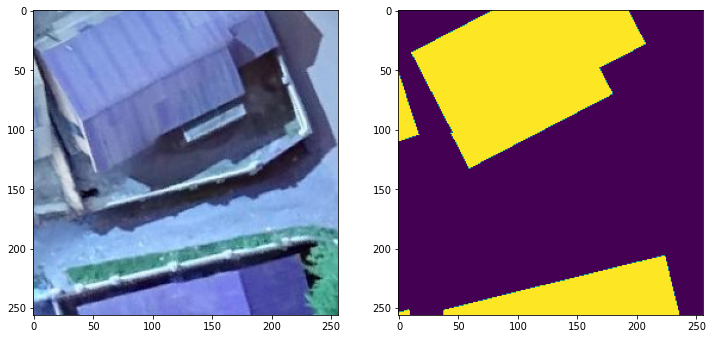

In [33]:
# checking...
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number])
plt.show()

In [55]:
n_classes = len(np.unique(labels)) # 2 classes...
labels = to_categorical(labels, num_classes=n_classes)

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size = 0.20, random_state = 42) # train test split for data...

In [57]:
### Modeling
# using weights from pretained resnet model...
BACKBONE = 'resnet34' 
preprocess_input = sm.get_preprocessing(BACKBONE)

In [58]:
# preprocess input...
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

In [59]:
# define model...
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='sigmoid')

In [60]:
# IoU as metrics, 
metrics=[sm.metrics.iou_score]
model_resnet_backbone.compile(optimizer='adam', loss=sm.losses.dice_loss, metrics=metrics)

In [61]:
model_resnet_backbone.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_68 (ZeroPadding  (None, None, None,   0          ['bn_data[0][0]']                
 2D)                            3)                                                          

In [62]:
# training the model for 100 epochs with batch size of 16...
history = model_resnet_backbone.fit(X_train_prepr, 
          y_train,
          batch_size=16, 
          epochs=100,
          verbose=1,
          validation_data=(X_test_prepr, y_test))

Epoch 1/100
8/8 [==============================] - 23s 996ms/step - loss: 0.4426 - iou_score: 0.4050 - val_loss: 0.7492 - val_iou_score: 0.1587
Epoch 2/100
8/8 [==============================] - 2s 239ms/step - loss: 0.3259 - iou_score: 0.5267 - val_loss: 0.7726 - val_iou_score: 0.1458
Epoch 3/100
8/8 [==============================] - 2s 240ms/step - loss: 0.2601 - iou_score: 0.5991 - val_loss: 0.7138 - val_iou_score: 0.1785
Epoch 4/100
8/8 [==============================] - 2s 238ms/step - loss: 0.2113 - iou_score: 0.6672 - val_loss: 0.3680 - val_iou_score: 0.4647
Epoch 5/100
8/8 [==============================] - 2s 239ms/step - loss: 0.1738 - iou_score: 0.7092 - val_loss: 0.4260 - val_iou_score: 0.4033
Epoch 6/100
8/8 [==============================] - 2s 240ms/step - loss: 0.1526 - iou_score: 0.7503 - val_loss: 0.5681 - val_iou_score: 0.3370
Epoch 7/100
8/8 [==============================] - 2s 241ms/step - loss: 0.1306 - iou_score: 0.7766 - val_loss: 0.5130 - val_iou_score: 0.386

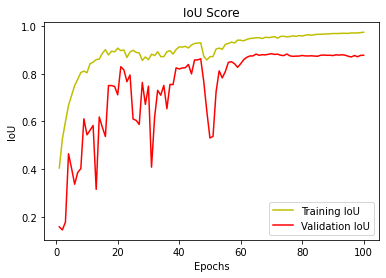

In [65]:
# plotting train and val accuracy in each epoch...
history = history
IoU = history.history['iou_score']
val_iou = history.history['val_iou_score']
epochs = range(1, len(IoU) + 1)
plt.plot(epochs, IoU, 'y', label='Training IoU')
plt.plot(epochs, val_iou, 'r', label='Validation IoU')
plt.title('IoU Score')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [66]:
# Saving model
model_resnet_backbone.save('/content/gdrive/MyDrive/HOT/resnet_backbone.hdf5')

In [73]:
model = model_resnet_backbone

In [74]:
#model = load_model('/content/gdrive/MyDrive/HOT/resnet_backbone.hdf5') # loading model...

In [75]:
# making predictions...
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

1/1 [==============================] - 3s 3s/step


In [91]:
# randomly selecting an image from the test set and making prediction...
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

1/1 [==============================] - 0s 20ms/step


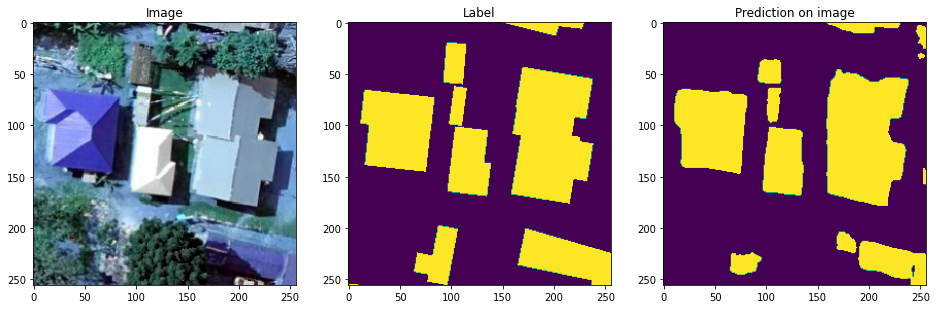

In [92]:
# plotting the image, test labeled image and predicted labeled image...
plt.figure(figsize=(16, 12))
plt.subplot(231)
plt.title('Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on image')
plt.imshow(predicted_img)
plt.show()

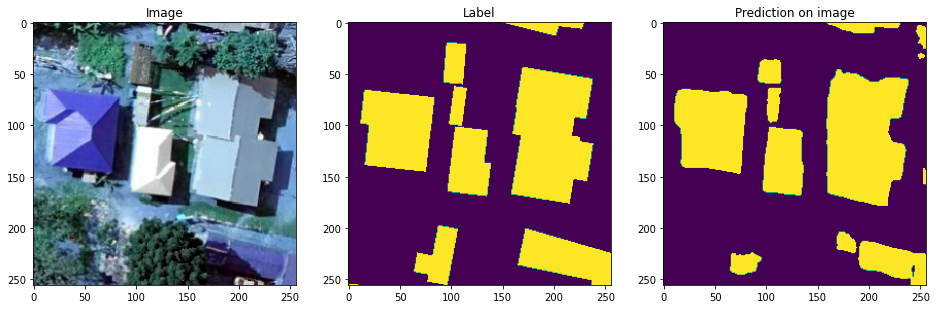

In [94]:
# plotting the image, test labeled image and predicted labeled image...
plt.figure(figsize=(16, 12))
plt.subplot(231)
plt.title('Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on image')
plt.imshow(predicted_img)
plt.show()